<a href="https://colab.research.google.com/github/Rakshithts/myprojects/blob/main/stock_analysis_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet yfinance stable-baselines3[extra] gym pandas matplotlib numpy

In [ ]:
# Cell 2: Imports and config
# -----------------------------
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gym
from gym import spaces
import os
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

In [ ]:
import numpy as np
np.bool8 = np.bool_ # or np.bool8 = boo

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Config - change these to try different settings
SYMBOL = 'AAPL' # ticker symbol
START = '2015-01-01' # data start
END = '2024-01-01' # data end (exclusive)
WINDOW = 30 # lookback window (days)
INIT_CASH = 10000 # starting capital
TRAIN_TIMESTEPS = 200_000 # training timesteps (reduce if you want faster runs)
MODEL_PATH = '/content/ppo_trader_aapl'

In [ ]:
# Cell 3: Data download
# -----------------------------
print('Downloading data for', SYMBOL)
df = yf.download(SYMBOL, start=START, end=END, progress=False)
if df.empty:
  raise ValueError('No data downloaded - check SYMBOL and dates')
# Use 'Close' as price column
df = df[['Open','High','Low','Close','Volume']].rename(columns={'Close':'close'})
df = df.reset_index(drop=True)
print('Data shape:', df.shape)

In [ ]:
df.head()

In [ ]:
!pip install shimmy


In [ ]:


# -----------------------------
# Cell 5: Train/val/test split and env creation
# -----------------------------
# We'll use a simple chronological split
train_frac = 0.7
val_frac = 0.15
n = len(df)
train_end = int(n * train_frac)
val_end = int(n * (train_frac + val_frac))


df_train = df.iloc[:train_end].reset_index(drop=True)
df_val = df.iloc[train_end:val_end].reset_index(drop=True)
df_test = df.iloc[val_end:].reset_index(drop=True)


print('Train/Val/Test shapes:', df_train.shape, df_val.shape, df_test.shape)

In [ ]:
# === Paste this entire cell ===
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# ---------- helper: flatten columns ----------
def flatten_columns(df):
    """Turn MultiIndex / tuple columns into single-level lowercase strings."""
    cols = []
    for col in df.columns:
        if isinstance(col, tuple):
            # keep non-empty parts and join with underscore
            parts = [str(x).strip() for x in col if x is not None and str(x).strip() != ""]
            joined = "_".join(parts) if parts else ""
        else:
            joined = str(col).strip()
        # normalize
        joined = joined.replace(" ", "_").replace("-", "_").lower()
        cols.append(joined)
    df = df.copy()
    df.columns = cols
    return df

# ---------- helper: find best price/close column ----------
def find_price_col(df):
    cols = list(df.columns)
    # priority 1: contains 'adj' and 'close'
    cands = [c for c in cols if ('adj' in c and 'close' in c)]
    # priority 2: contains 'close'
    if not cands:
        cands = [c for c in cols if 'close' in c]
    # priority 3: contains 'price'
    if not cands:
        cands = [c for c in cols if 'price' in c]
    # priority 4: any numeric column
    if not cands:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            return numeric_cols[0]
        return None
    # prefer candidate containing ticker suffix (e.g., '_aapl') or 'adj'
    for cand in cands:
        if 'adj' in cand:
            return cand
    # else return longest match (most specific)
    return sorted(cands, key=lambda x: len(x), reverse=True)[0]

# ---------- Apply flattening to your split dfs ----------
# NOTE: assumes df_train, df_val, df_test already exist in the notebook.
df_train = flatten_columns(df_train)
df_val   = flatten_columns(df_val)
df_test  = flatten_columns(df_test)

print("Columns (train):", df_train.columns.tolist())
print("Columns (val)  :", df_val.columns.tolist())
print("Columns (test) :", df_test.columns.tolist())

# ---------- detect price column from train set ----------
price_col = find_price_col(df_train)
print("Detected price column (from train):", price_col)
if price_col is None:
    raise KeyError("No suitable price column found in df_train. Please paste df_train.columns output.")

# sanity check presence in all splits
print("price_col in train?", price_col in df_train.columns)
print("price_col in val?  ", price_col in df_val.columns)
print("price_col in test? ", price_col in df_test.columns)

# If the column is missing in val/test, try to find a matching close column there too:
if not (price_col in df_val.columns and price_col in df_test.columns):
    # try find separate
    price_col_val = find_price_col(df_val)
    price_col_test = find_price_col(df_test)
    print("Alternative price_col (val):", price_col_val)
    print("Alternative price_col (test):", price_col_test)
    # prefer the explicit train price_col, but if absent in val/test, use their own
else:
    price_col_val = price_col_test = price_col

# ---------- Safe Trading Env (uses detected price column) ----------
class SimpleTradingEnv(gym.Env):
    def __init__(self, df, window=30, init_cash=10000, price_col=None):
        super(SimpleTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True).copy()
        self.window = window
        self.init_cash = float(init_cash)

        # detect price column if not provided
        if price_col is None:
            pcol = find_price_col(self.df)
        else:
            pcol = price_col
        if pcol is None or pcol not in self.df.columns:
            raise KeyError(f"price_col '{pcol}' not found in dataframe columns: {self.df.columns.tolist()[:20]}")
        self.price_col = pcol
        self.prices = self.df[self.price_col].values.astype(float)

        # actions: hold, buy 1, sell 1
        self.action_space = spaces.Discrete(3)
        # observation: window-1 returns + holdings
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.t = self.window
        self.cash = float(self.init_cash)
        self.holdings = 0
        self.done = False
        return self._get_obs()

    def _get_obs(self):
        # safe slice
        if self.t < self.window:
            window_prices = self.prices[: self.t + 1]
        else:
            window_prices = self.prices[self.t - self.window : self.t]

        if len(window_prices) > 1:
            returns = np.diff(window_prices) / window_prices[:-1]
        else:
            returns = np.array([])

        returns = np.ravel(returns)
        target_len = self.window - 1
        # pad or trim to exactly target_len
        if len(returns) < target_len:
            returns = np.pad(returns, (target_len - len(returns), 0), 'constant')
        else:
            returns = returns[-target_len:]

        obs = np.concatenate([returns, [self.holdings]])
        # debug print for first few timesteps
        if self.t < self.window + 3:
            print(f"DEBUG env price_col='{self.price_col}' t={self.t} window_prices={len(window_prices)} returns={returns.shape} obs={obs.shape}")
        return obs.astype(np.float32)

    def step(self, action):
        if self.done:
            return self._get_obs(), 0.0, True, {}
        price = float(self.prices[self.t])
        # simple execution (no costs)
        if action == 1 and self.cash >= price:
            self.cash -= price
            self.holdings += 1
        elif action == 2 and self.holdings > 0:
            self.cash += price
            self.holdings -= 1

        self.t += 1
        portfolio_value = self.cash + self.holdings * price
        reward = portfolio_value - self.init_cash
        if self.t >= len(self.prices) - 1:
            self.done = True
        return self._get_obs(), float(reward), bool(self.done), {'pv': portfolio_value}

# Recreate environments after fixing the class
train_env = DummyVecEnv([lambda: SimpleTradingEnv(df_train, window=WINDOW, init_cash=INIT_CASH)])
val_env   = DummyVecEnv([lambda: SimpleTradingEnv(df_val, window=WINDOW, init_cash=INIT_CASH)])
test_env  = SimpleTradingEnv(df_test, window=WINDOW, init_cash=INIT_CASH)

# normalize only training env (observations)
vec_norm = VecNormalize(train_env, norm_obs=True, norm_reward=False, clip_obs=10.)
print("Created train_env, val_env, test_env and VecNormalize.")
# === End cell ===




In [ ]:
from stable_baselines3 import PPO

# Create PPO model
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    tensorboard_log="./ppo_trading_tensorboard/"
)


In [ ]:
# Train for some timesteps (you can increase later)
model.learn(total_timesteps=50_000)

# Save model
model.save("ppo_trading_model")


In [ ]:
# Evaluate on validation environment
obs = val_env.reset()
for _ in range(500):  # adjust steps
    action, _ = model.predict(obs)
    obs, reward, done, info = val_env.step(action)
    if done:
        obs = val_env.reset()


In [ ]:

test_env = SimpleTradingEnv(df_test, window=WINDOW, init_cash=INIT_CASH)

obs = test_env.reset()
portfolio_values = []

for _ in range(len(df_test)):
    action, _ = model.predict(obs)
    obs, reward, done, info = test_env.step(action)
    portfolio_values.append(info['pv'])
    if done:
        break

print("Final portfolio value:", portfolio_values[-1])


In [ ]:
import matplotlib.pyplot as plt

# --- PPO agent evaluation ---
test_env = SimpleTradingEnv(df_test, window=WINDOW, init_cash=INIT_CASH)
obs = test_env.reset()
ppo_pv = []

for _ in range(len(df_test)):
    action, _ = model.predict(obs)
    obs, reward, done, info = test_env.step(action)
    ppo_pv.append(info['pv'])
    if done:
        break

# --- Buy-and-hold baseline ---
prices = test_env.prices
buy_and_hold_shares = INIT_CASH / prices[WINDOW]  # invest all cash at first available step
bh_pv = buy_and_hold_shares * prices[WINDOW:WINDOW+len(ppo_pv)]

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(ppo_pv, label="PPO Agent")
plt.plot(bh_pv, label="Buy & Hold")
plt.title("Portfolio Value: PPO vs Buy & Hold")
plt.xlabel("Timesteps")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

print("Final PPO Portfolio Value:", ppo_pv[-1])
print("Final Buy & Hold Portfolio Value:", bh_pv[-1])


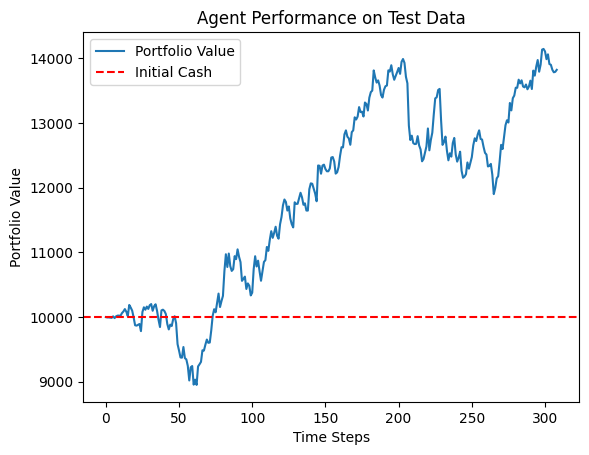

In [ ]:
import matplotlib.pyplot as plt

plt.plot(pv_history_test, label="Portfolio Value")
plt.axhline(10000, color="red", linestyle="--", label="Initial Cash")
plt.legend()
plt.title("Agent Performance on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.show()


DEBUG env price_col='close_aapl' t=30 window_prices=30 returns=(29,) obs=(30,)
DEBUG env price_col='close_aapl' t=31 window_prices=30 returns=(29,) obs=(30,)
DEBUG env price_col='close_aapl' t=32 window_prices=30 returns=(29,) obs=(30,)


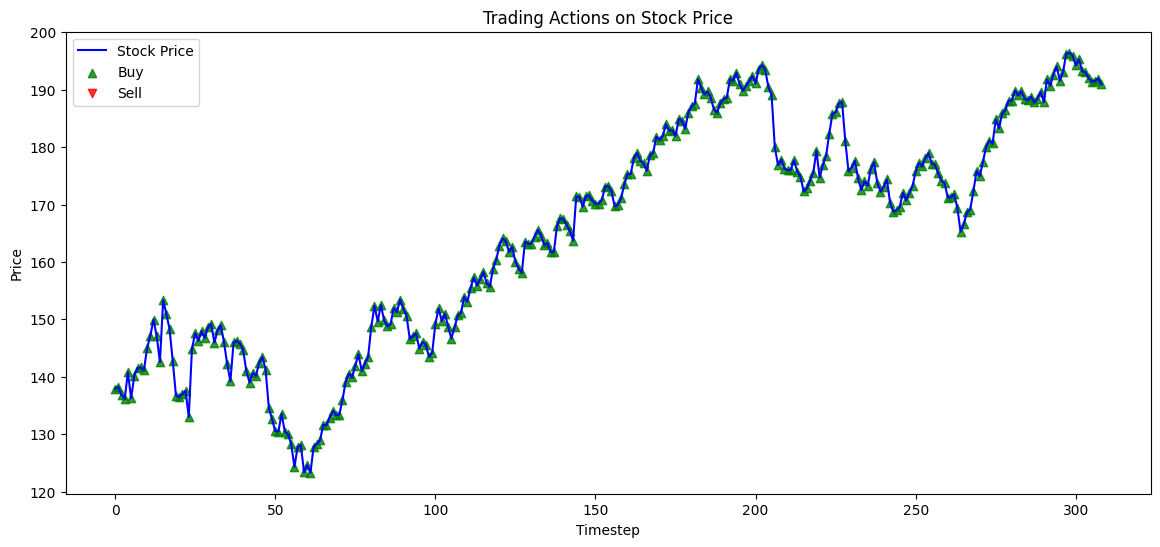

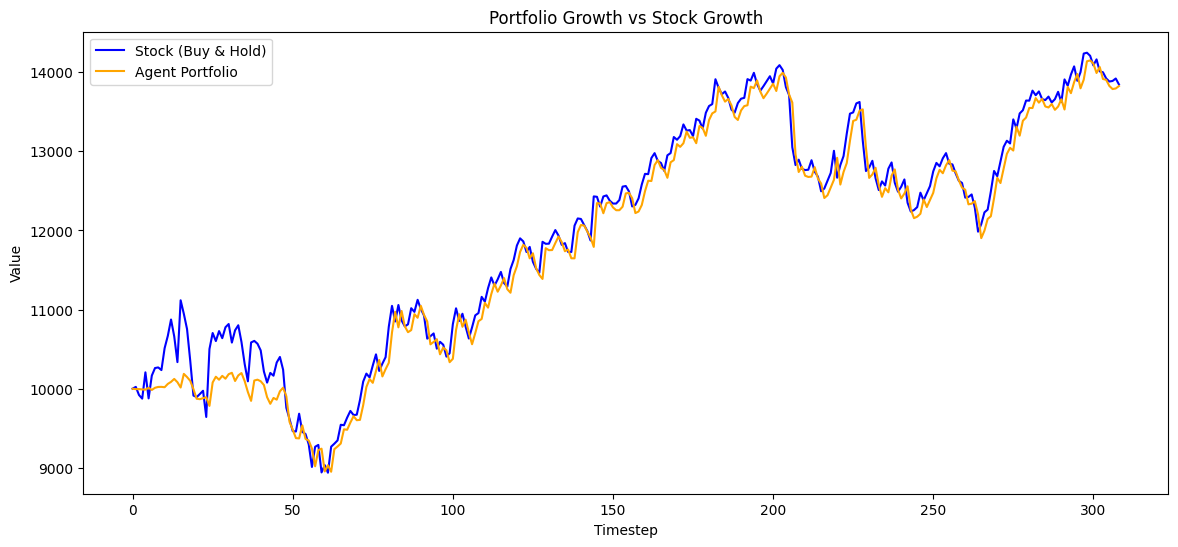

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ---------- Run test phase again but record history ----------
obs = test_env.reset()   # ✅ Only obs, no info
portfolio_values = []
prices = []
actions_taken = []

for _ in range(len(df_test) - WINDOW - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)

    portfolio_values.append(info["pv"])
    prices.append(test_env.prices[test_env.t])
    actions_taken.append(action)

    if done:
        break

# ---------- Plot 1: Price with Buy/Sell markers ----------
plt.figure(figsize=(14,6))
plt.plot(prices, label="Stock Price", color="blue")

buy_idx = [i for i,a in enumerate(actions_taken) if a == 1]
sell_idx = [i for i,a in enumerate(actions_taken) if a == 2]

plt.scatter(buy_idx, [prices[i] for i in buy_idx], marker="^", color="green", label="Buy", alpha=0.8)
plt.scatter(sell_idx, [prices[i] for i in sell_idx], marker="v", color="red", label="Sell", alpha=0.8)

plt.title("Trading Actions on Stock Price")
plt.xlabel("Timestep")
plt.ylabel("Price")
plt.legend()
plt.show()

# ---------- Plot 2: Portfolio Growth vs Stock ----------
plt.figure(figsize=(14,6))

# normalize stock to initial portfolio value for comparison
stock_growth = np.array(prices) / prices[0] * INIT_CASH
plt.plot(stock_growth, label="Stock (Buy & Hold)", color="blue")
plt.plot(portfolio_values, label="Agent Portfolio", color="orange")

plt.title("Portfolio Growth vs Stock Growth")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()
